In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score
import pickle

In [22]:
# 加载 MNIST 数据集
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
y_train_one_hot = np.eye(10)[y_train]
y_test_one_hot = np.eye(10)[y_test]

# 定义神经网络的结构
input_dim = x_train.shape[1]
hidden_dim = 100
output_dim = 10
learning_rate = 1e-4
reg_lambda = 1e-5
decay_rate = 1e-1

# 初始化参数
w1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(1 / input_dim)
b1 = np.zeros(hidden_dim)
w2 = np.random.randn(hidden_dim, output_dim)* np.sqrt(1 / hidden_dim)
b2 = np.zeros(output_dim)

# 定义 ReLU 激活函数
def relu(x):
    return np.maximum(0, x)

# 定义 softmax 函数
def softmax(x):
    x -= np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x)
    softmax_x = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return  softmax_x

# 定义损失函数（交叉熵）
def cross_entropy_loss(y_pred, y_true):
    num_samples = y_pred.shape[0]
    probs = softmax(y_pred)
    log_probs = -np.log(probs[np.arange(num_samples), y_true])
    loss = np.sum(log_probs) / num_samples
    return loss

# 定义学习率下降策略函数
def learning_rate_decay(initial_lr, decay_rate, epoch):
    lr = initial_lr * (1 / (1 + decay_rate * epoch))
    return lr

# 定义训练函数
def train(x, y_true,epoch):
    
    global w1, b1, w2, b2
    
    # 前向传播
    hidden_layer = np.dot(x, w1) + b1
    hidden_layer = relu(hidden_layer)
    output_layer = np.dot(hidden_layer, w2) + b2

    # 计算损失和梯度
    loss = cross_entropy_loss(output_layer, y_true) + 0.5 * reg_lambda * np.sum(w1**2) + 0.5 * reg_lambda * np.sum(w2**2) # L2正则化
    delta_output = softmax(output_layer)
    delta_output[np.arange(y_true.shape[0]), y_true] -= 1
    delta_w2 = np.dot(hidden_layer.T, delta_output) / y_true.shape[0]
    delta_b2 = np.sum(delta_output, axis=0) / y_true.shape[0]
    delta_hidden = np.dot(delta_output, w2.T)
    delta_hidden[hidden_layer <= 0] = 0
    delta_w1 = np.dot(x.T, delta_hidden) / y_true.shape[0]
    delta_b1 = np.sum(delta_hidden, axis=0) / y_true.shape[0]

    # 更新参数 优化器SGD
    delta_w2 += reg_lambda * w2
    delta_w1 += reg_lambda * w1

    lr = learning_rate_decay(learning_rate,decay_rate,epoch) # 学习率下降策略

    w1 -= lr * delta_w1
    b1 -= lr * delta_b1
    w2 -= lr * delta_w2
    b2 -= lr * delta_b2

    return loss

# 定义预测函数
def predict(x):
    hidden_layer = np.dot(x, w1) + b1
    hidden_layer = relu(hidden_layer)
    output_layer = np.dot(hidden_layer, w2) + b2
    probs = softmax(output_layer)
    return np.argmax(probs, axis=1)

# 初始化训练参数
num_epochs = 20
batch_size = 16
num_batches = x_train.shape[0] // batch_size
train_losses = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    
    train_loss= 0.0
    
    for batch in range(num_batches):
        
        # 获取当前batch的数据和标签
        batch_start = batch * batch_size
        batch_end = (batch + 1) * batch_size
        x_batch = x_train[batch_start:batch_end]
        y_batch = y_train_one_hot[batch_start:batch_end]

        # 训练模型并记录loss
        train_loss += train(x_batch, y_train[batch_start:batch_end],epoch)

    train_losses.append(train_loss/num_batches)
    print('Epoch {} Train loss: {:.3f}'.format(epoch + 1, train_loss/num_batches))
    
    # 在每个epoch结束后测试模型并记录loss和accuracy
    test_loss = cross_entropy_loss(np.dot(relu(np.dot(x_test, w1) + b1), w2) + b2, y_test)
    test_losses.append(test_loss)
    test_acc = accuracy_score(y_test, predict(x_test))
    test_accs.append(test_acc)
    print('Epoch: {}/{}, Test loss: {:.3f}, Test accuracy: {:.3f}'.format(epoch + 1, num_epochs, test_loss, test_acc))

# 保存模型参数到 pickle文件中
params = {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2}
with open('train.pkl', 'wb') as f:
    pickle.dump(params, f)    

Epoch 1 Train loss: 2.277
Epoch: 1/20, Test loss: 0.817, Test accuracy: 0.882
Epoch 2 Train loss: 0.600
Epoch: 2/20, Test loss: 0.518, Test accuracy: 0.899
Epoch 3 Train loss: 0.408
Epoch: 3/20, Test loss: 0.431, Test accuracy: 0.909
Epoch 4 Train loss: 0.330
Epoch: 4/20, Test loss: 0.392, Test accuracy: 0.916
Epoch 5 Train loss: 0.285
Epoch: 5/20, Test loss: 0.368, Test accuracy: 0.920
Epoch 6 Train loss: 0.255
Epoch: 6/20, Test loss: 0.351, Test accuracy: 0.924
Epoch 7 Train loss: 0.232
Epoch: 7/20, Test loss: 0.339, Test accuracy: 0.927
Epoch 8 Train loss: 0.215
Epoch: 8/20, Test loss: 0.328, Test accuracy: 0.930
Epoch 9 Train loss: 0.201
Epoch: 9/20, Test loss: 0.320, Test accuracy: 0.932
Epoch 10 Train loss: 0.190
Epoch: 10/20, Test loss: 0.312, Test accuracy: 0.932
Epoch 11 Train loss: 0.181
Epoch: 11/20, Test loss: 0.307, Test accuracy: 0.933
Epoch 12 Train loss: 0.173
Epoch: 12/20, Test loss: 0.302, Test accuracy: 0.934
Epoch 13 Train loss: 0.166
Epoch: 13/20, Test loss: 0.298,

In [23]:
# 导入模型参数
with open('train.pkl', 'rb') as f:
    params = pickle.load(f)
w1 = params['w1']
b1 = params['b1']
w2 = params['w2']
b2 = params['b2']

# 测试，输出分类精度
acc = accuracy_score(y_test, predict(x_test))
print('导入保存的模型，用经过参数查找后的模型进行测试，分类精度为：', acc)

导入保存的模型，用经过参数查找后的模型进行测试，分类精度为： 0.9383


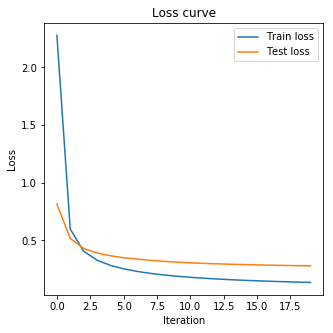

In [24]:
# 可视化训练和测试的 loss 曲线
plt.figure(figsize=(5,5))
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.title('Loss curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

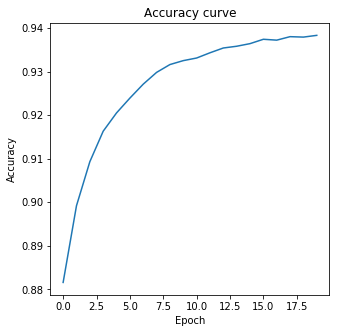

In [25]:
# 可视化测试的 accuracy 曲线
plt.figure(figsize=(5,5))
plt.plot(test_accs)
plt.title('Accuracy curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

<Figure size 720x720 with 0 Axes>

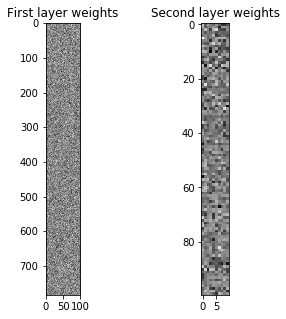

In [26]:
# 可视化每层的网络参数
plt.figure(figsize=(10,10))
fig, ax = plt.subplots(1, 2, figsize=(5,5))
ax[0].imshow(w1, cmap='gray')
ax[0].set_title('First layer weights')
ax[1].imshow(w2, cmap='gray')
ax[1].set_title('Second layer weights')
plt.show()